In [4]:
import numpy as np
import gymnasium as gym
import matplotlib.pyplot as plt
from collections import defaultdict
import seaborn as sns
from collections import defaultdict
import copy 
import matplotlib.animation as animation


In [37]:
def createHeatMap(q_value_snapshots, snapshot_intervals, env):
    cols = 1  # Number of columns
    rows = 5  # Fixed to 2 rows
    all_q_values = np.concatenate([
        np.array([list(snapshot.get(state, np.zeros(env.action_space.n))) for state in range(env.observation_space.n)])
        for snapshot in q_value_snapshots
    ])
    vmin, vmax = np.min(all_q_values), np.max(all_q_values)

    # Create subplots with 2 rows
    fig, axes = plt.subplots(rows, cols, figsize=(6, 25))  # Adjust height to fit better
    axes = axes.flatten()  # Flatten axes for easier indexing

    for i, q_snapshot in enumerate(q_value_snapshots):
        q_table_array = np.zeros((env.observation_space.n, env.action_space.n))
        
        for state in range(env.observation_space.n):
            q_table_array[state] = q_snapshot.get(state, np.zeros(env.action_space.n))  # Ensure all states exist

        sns.heatmap(q_table_array, annot=True, cmap="coolwarm", cbar=True, ax=axes[i], vmin=vmin, vmax=vmax)
        axes[i].set_title(f"Q-values at Episode {snapshot_intervals[i]}")
        axes[i].set_xlabel("Actions (0=Left, 1=Down, 2=Right, 3=Up)")
        axes[i].set_ylabel("States")

    # Hide any unused subplots (if len(q_value_snapshots) is odd)
    for j in range(i + 1, len(axes)):
        axes[j].axis("off")

    plt.suptitle("Q-value Evolution Over Training", fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout to fit title
    plt.show()
    createHeatMapAnimation(q_value_snapshots, snapshot_intervals, env)


def createHeatMapAnimation(q_value_snapshots, snapshot_intervals, env):
    fig, ax = plt.subplots(figsize=(6, 5))

    # Find global min and max values for consistent color scaling
    all_q_values = np.concatenate([
        np.array([list(snapshot.get(state, np.zeros(env.action_space.n))) for state in range(env.observation_space.n)])
        for snapshot in q_value_snapshots
    ])

    vmin, vmax = np.min(all_q_values), np.max(all_q_values)  # Fixed color range

    # Initialize first Q-table
    q_table_array = np.zeros((env.observation_space.n, env.action_space.n))

    # Create the initial heatmap with fixed vmin, vmax
    heatmap = sns.heatmap(q_table_array, annot=True, cmap="coolwarm", cbar=True, ax=ax, vmin=vmin, vmax=vmax)
    cbar = heatmap.collections[0].colorbar  # Store the colorbar reference

    def update(frame):
        """Update the heatmap for each frame without changing the color scale."""
        q_snapshot = q_value_snapshots[frame]

        # Update Q-table array with the new snapshot
        for state in range(env.observation_space.n):
            q_table_array[state] = q_snapshot.get(state, np.zeros(env.action_space.n))  # Ensure all states exist

        # Clear old heatmap but keep the color scale
        ax.clear()

        # Redraw heatmap with consistent color scale
        sns.heatmap(q_table_array, annot=True, cmap="coolwarm", cbar=False, ax=ax, vmin=vmin, vmax=vmax)

        ax.set_title(f"Q-values at Episode {snapshot_intervals[frame]}")
        ax.set_xlabel("Actions (0=Left, 1=Down, 2=Right, 3=Up)")
        ax.set_ylabel("States")

    # Create the animation
    anim = animation.FuncAnimation(fig, update, frames=len(q_value_snapshots), repeat=True)

    # Save as GIF
    gif_filename = "q_table_animation.gif"
    anim.save(gif_filename, writer=animation.PillowWriter(fps=1))
    print(f"✅ Animation saved as {gif_filename}")

def visualizeStateVisits(state_visits, env):
    visit_grid = np.zeros((4, 4))
    
    for state, visits in state_visits.items():
        visit_grid[state // 4, state % 4] = visits

    plt.figure(figsize=(5, 5))
    sns.heatmap(visit_grid, annot=True, cmap="Greens", fmt=".0f")
    plt.title("State Visit Frequency")
    plt.show()

import matplotlib.pyplot as plt

def plotRewards(reward_history, window_size=100):
    """ Line plot of total rewards over episodes with smoothing. """
    smoothed_rewards = np.convolve(reward_history, np.ones(window_size)/window_size, mode='valid')

    plt.figure(figsize=(10, 5))
    plt.plot(smoothed_rewards, label=f"Smoothed Rewards (window={window_size})", color="blue", linewidth=2)
    plt.xlabel("Episodes")
    plt.ylabel("Average Reward")
    plt.title("Training Progress - Smoothed Rewards Over Time")
    plt.legend()
    plt.show()

def getBestActionsPerState(env, Q, ACTION_MAP):
    policy_grid = np.full((4, 4), ' ', dtype=str)
    for state in range(env.observation_space.n):
        best_action = np.argmax(Q[state])
        policy_grid[state // 4, state % 4] = ACTION_MAP[best_action]

    print("\nBest Actions Learned by Q-Learning:")
    for row in policy_grid:
        print("  ".join(row))
    


In [ ]:
def reinforcement_learning(alpha=0.1, gamma=0.9, epsilon=1.0, epsilon_decay=0.999, epsilon_min=0.1, episodes=5001):
    ACTION_MAP = {0: '←', 1: '↓', 2: '→', 3: '↑'}
    env = gym.make("FrozenLake-v1", is_slippery=False, render_mode="ansi")
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    
    q_value_snapshots = []  # Store Q-table at different intervals
    snapshot_intervals = [0, 100, 500, 1000, 5000]  # Capture Q-values at these episodes
    state_visits = defaultdict(int)  # Track state visit frequency
    reward_history = []  # Track total rewards per episode

    for episode in range(episodes):
        state, _ = env.reset()
        done = False
        total_reward = 0  # Track cumulative reward for this episode

        while not done:

            state_visits[state] += 1  # 🔹 Track visits
            
            if np.random.rand() < epsilon:
                action = env.action_space.sample()
            else:
                action = np.argmax(Q[state])

            next_state, reward, done, _, _ = env.step(action)
            best_next_action = np.argmax(Q[next_state])
            Q[state][action] += alpha * (reward + gamma * Q[next_state][best_next_action] - Q[state][action])
            state = next_state

            total_reward += reward  # 🔹 Accumulate reward

        epsilon = max(epsilon * epsilon_decay, epsilon_min)  # Reduce exploration over time
        reward_history.append(total_reward)

        # 🔹 Store **actual copies** of Q-values at specific intervals
        if episode in snapshot_intervals:
            q_value_snapshots.append(copy.deepcopy(dict(Q)))  

    print("Reinforcement Learning - Q-Learning Training Complete")

    print("\nFrozenLake Map:")
    print(env.render())
    return env, Q, ACTION_MAP, q_value_snapshots, snapshot_intervals, state_visits, reward_history


In [39]:
env, Q, ACTION_MAP, q_value_snapshots, snapshot_intervals, state_visits, reward_history = reinforcement_learning()
getBestActionsPerState(env, Q, ACTION_MAP)


Reinforcement Learning - Q-Learning Training Complete

FrozenLake Map:
  (Right)
SFFF
FHFH
FFFH
HFFG


Best Actions Learned by Q-Learning:
↓  ←  ↓  ←
↓  ←  ↓  ←
→  →  ↓  ←
←  →  →  ←


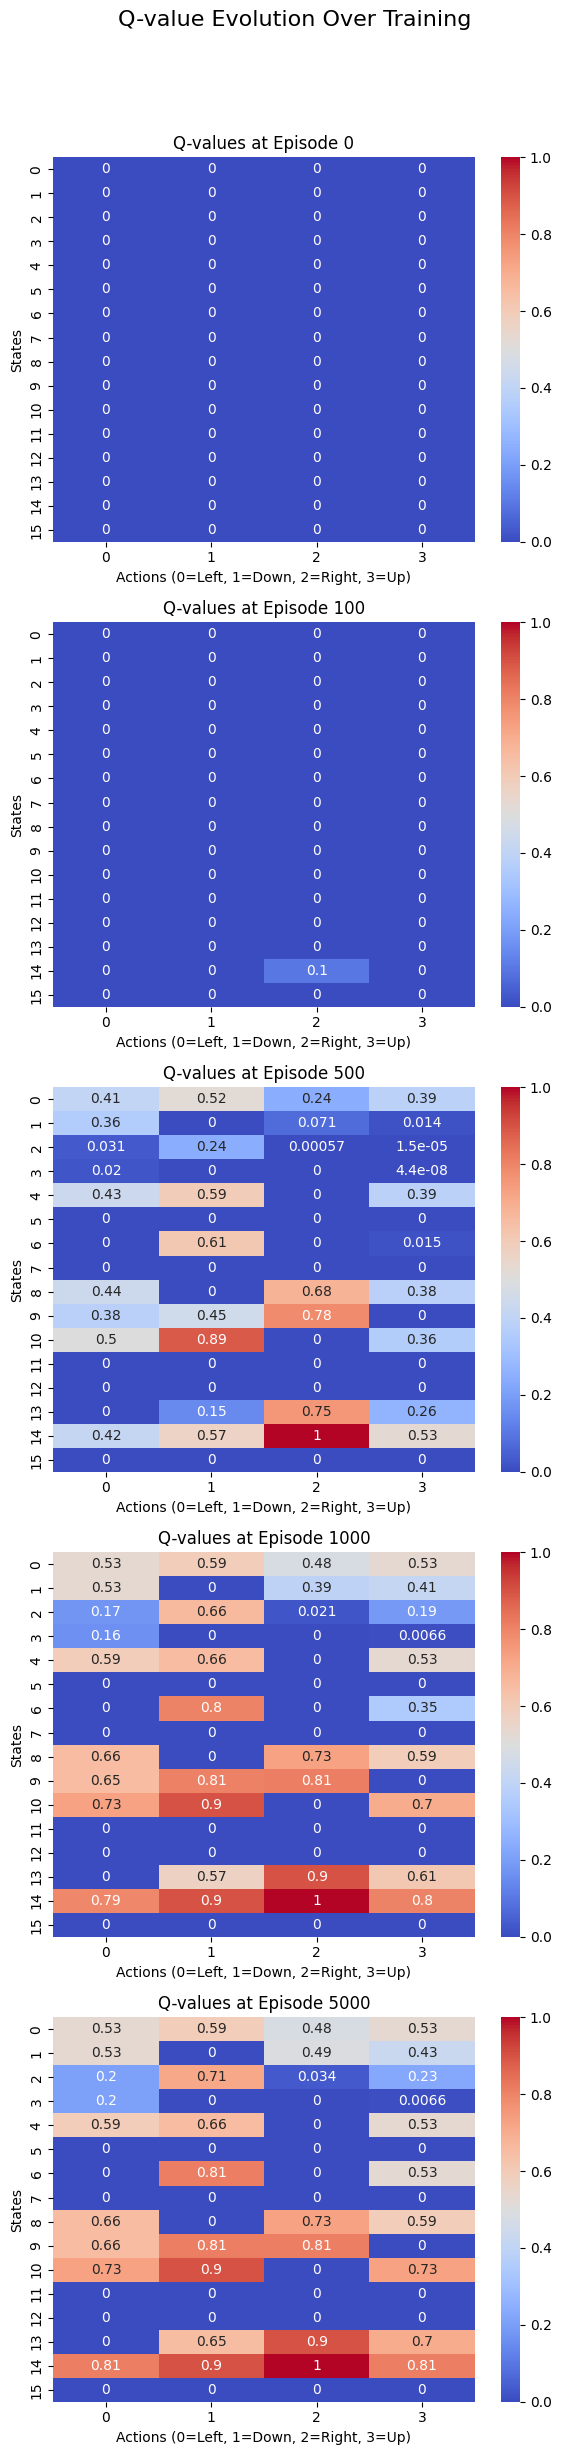

✅ Animation saved as q_table_animation.gif


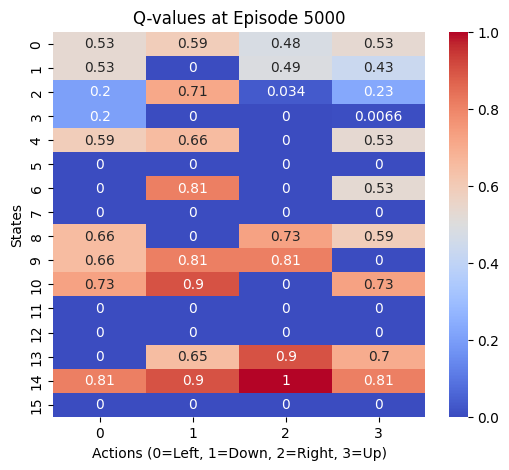

In [40]:
createHeatMap(q_value_snapshots, snapshot_intervals, env)


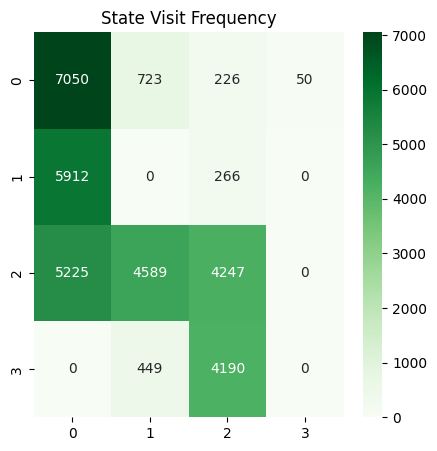

In [41]:
visualizeStateVisits(state_visits, env)


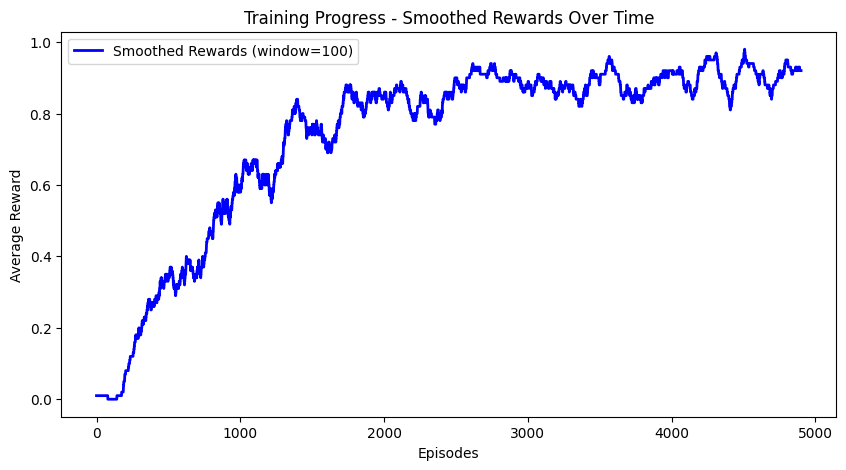

In [42]:
plotRewards(reward_history)

Reinforcement Learning - Q-Learning Training Complete

FrozenLake Map:
  (Right)
SFFF
FHFH
FFFH
HFFG



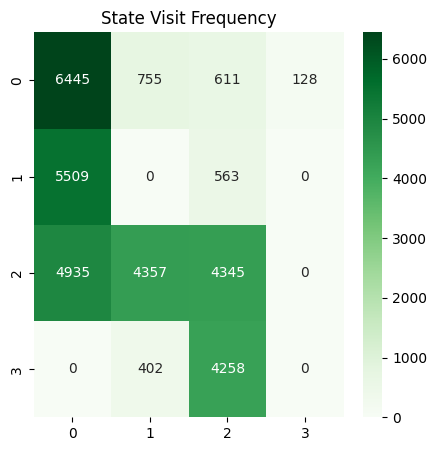

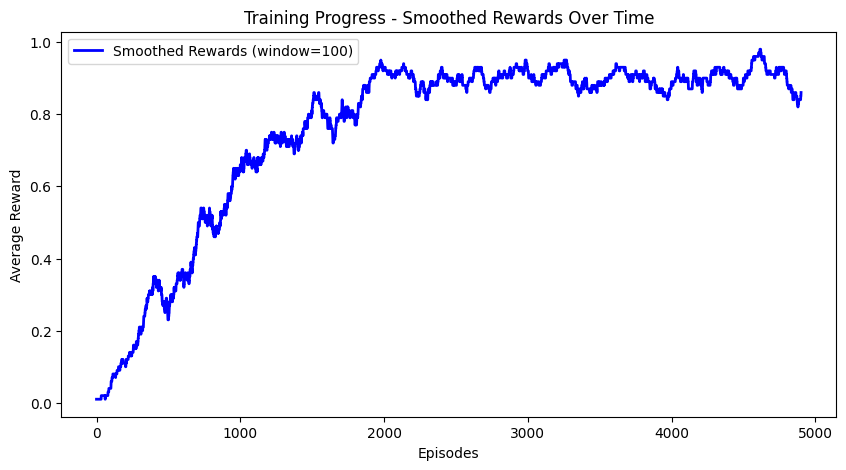

In [46]:
env, Q, ACTION_MAP, q_value_snapshots, snapshot_intervals, state_visits, reward_history = reinforcement_learning(epsilon_decay=0.999)
visualizeStateVisits(state_visits, env)
plotRewards(reward_history)
